##importing libraries

الكود يقوم باستيراد جميع المكتبات والأدوات اللازمة لتحليل البيانات، معالجة البيانات، بناء نماذج تصنيف، وتقييم الأداء.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.inspection import permutation_importance
from scipy import stats
warnings.filterwarnings('ignore')
plt.style.use('ggplot')
sns.set(style='whitegrid', rc={'figure.figsize': (12, 8)})
pd.set_option('display.max_columns', 100)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
start_time = time.time()


##Importing Data

In [6]:
df = pd.read_csv("/content/sample_data/diabetes.csv")
print(df.head())


   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


##Data visualization

توزيع فئات السكري 0: لا يوجد, 1: يوجد

Outcome
0    500
1    268
Name: count, dtype: int64


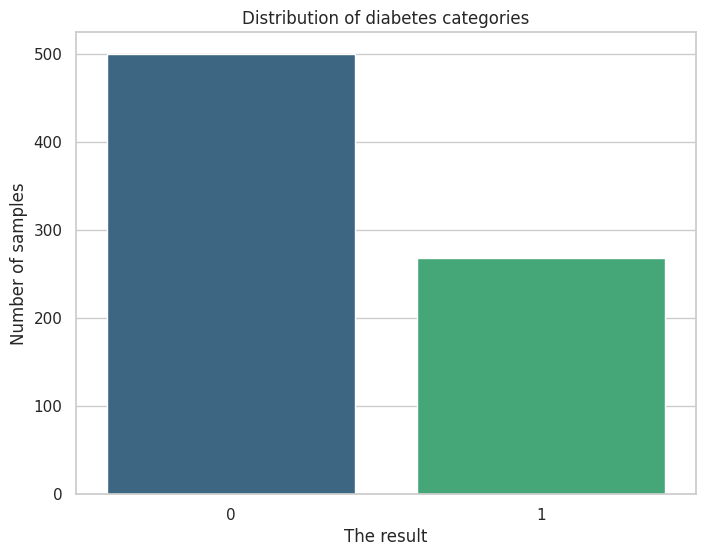

In [10]:
class_distribution = df['Outcome'].value_counts()
print(class_distribution)
plt.figure(figsize=(8, 6))
sns.countplot(x='Outcome', data=df, palette='viridis')
plt.title('Distribution of diabetes categories')
plt.xlabel('The result')
plt.ylabel('Number of samples')
plt.show()


##Handle outliers

In [13]:
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
for feature in zero_features:
    df[feature] = df[feature].replace(0, np.nan)

missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'القيم المفقودة': missing_values, 'النسبة المئوية': missing_percent})
print(missing_df[missing_df['القيم المفقودة'] > 0])

               القيم المفقودة  النسبة المئوية
Glucose                     5        0.651042
BloodPressure              35        4.557292
SkinThickness             227       29.557292
Insulin                   374       48.697917
BMI                        11        1.432292


##Correlation matrix

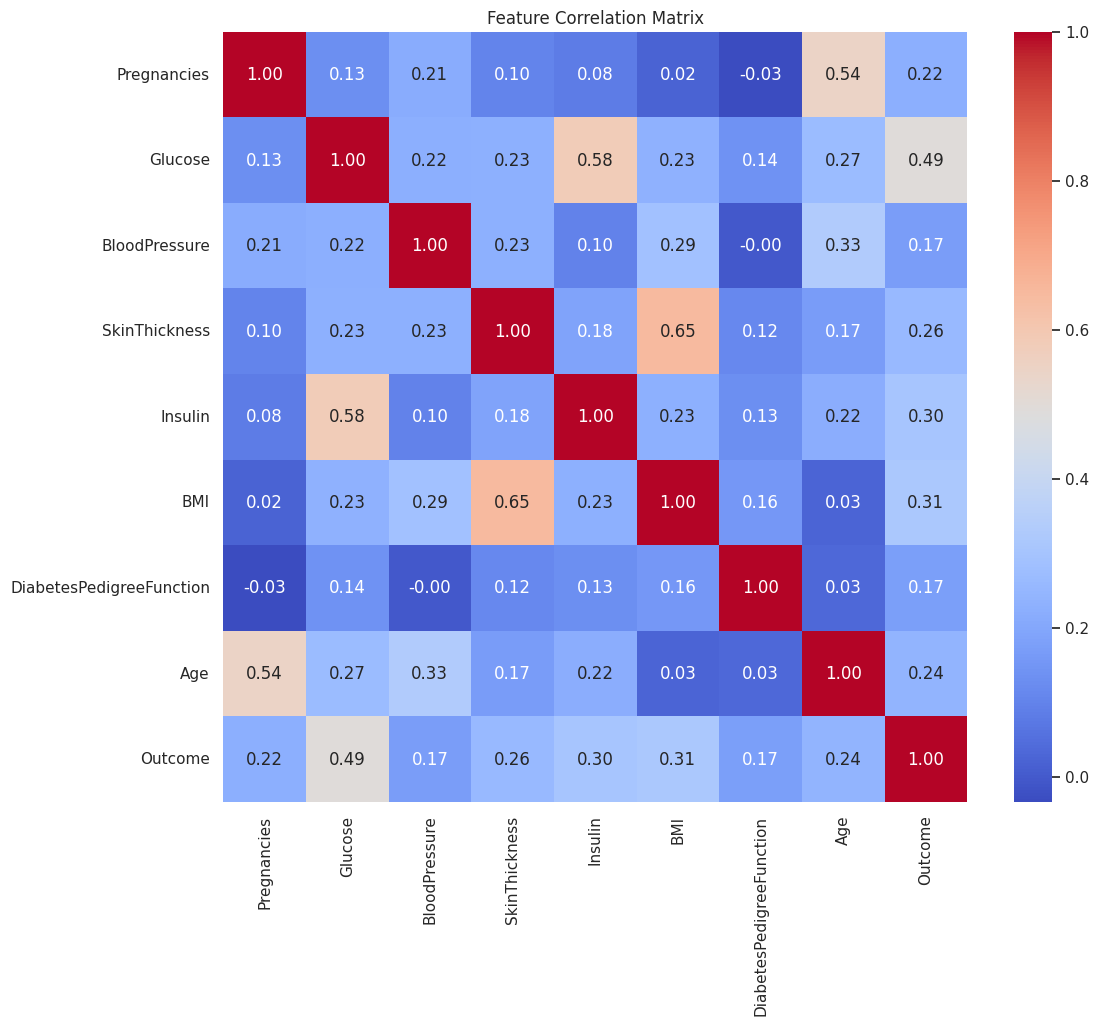

In [16]:
plt.figure(figsize=(12, 10))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()


توزيع الميزات:


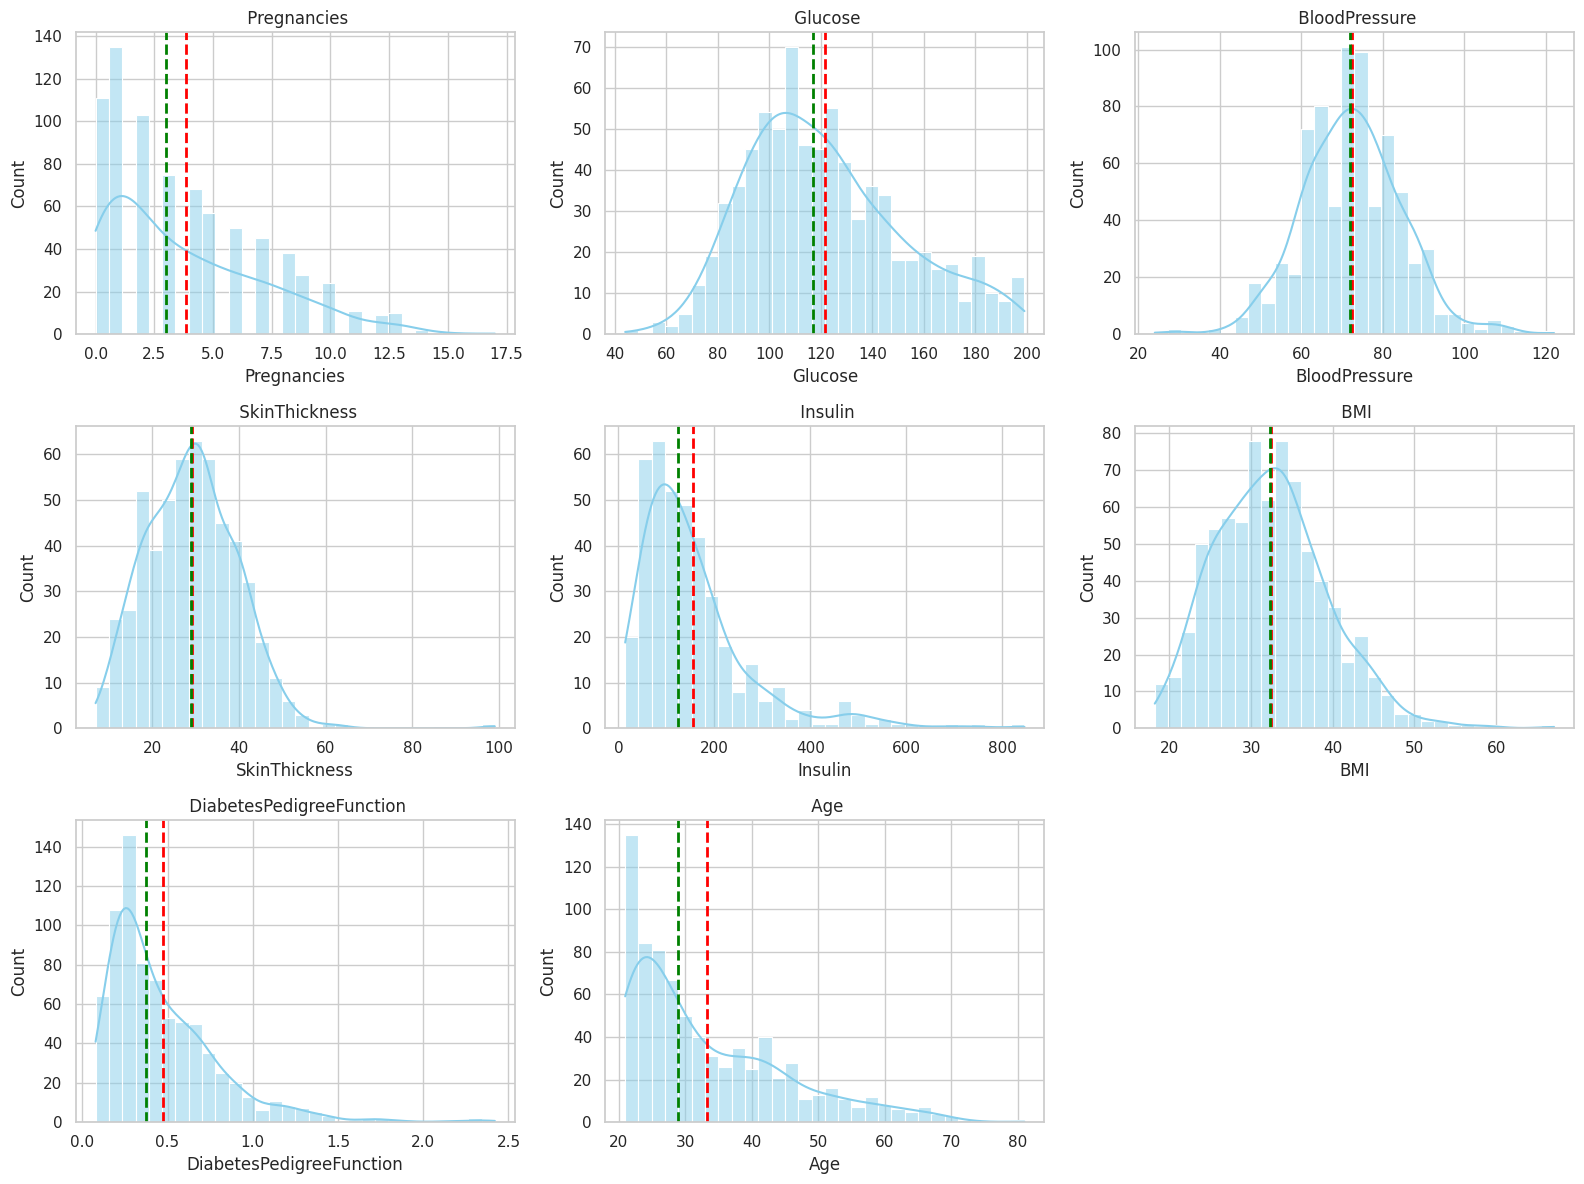

In [18]:
print("\nتوزيع الميزات:")
plt.figure(figsize=(16, 12))
for i, column in enumerate(df.columns[:-1]):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[column], kde=True, bins=30, color='skyblue')
    plt.axvline(df[column].mean(), color='red', linestyle='dashed', linewidth=2)
    plt.axvline(df[column].median(), color='green', linestyle='dashed', linewidth=2)
    plt.title(f' {column}')
plt.tight_layout()
plt.show()

##Data processing

In [22]:
for feature in zero_features:
    df[feature] = df.groupby('Outcome')[feature].transform(lambda x: x.fillna(x.median()))

df.fillna(df.median(), inplace=True)

df['Glucose_BMI_Ratio'] = df['Glucose'] / df['BMI']
df['BloodPressure_Glucose_Product'] = df['BloodPressure'] * df['Glucose']
df['Insulin_Glucose_Ratio'] = df['Insulin'] / df['Glucose']
df['Age_BMI_Interaction'] = df['Age'] * df['BMI']
df['Metabolic_Syndrome_Index'] = (df['Glucose'] * df['Insulin']) / (df['BMI'] + 1e-6)
df['Diabetes_Pedigree_Age'] = df['DiabetesPedigreeFunction'] * df['Age']

skewed_features = ['Insulin', 'SkinThickness', 'Age_BMI_Interaction', 'DiabetesPedigreeFunction']
for feature in skewed_features:
    df[feature + '_log'] = np.log1p(df[feature])

# 4.4 معالجة القيم المتطرفة
print("\nمعالجة القيم المتطرفة...")
for feature in df.columns:
    if feature != 'Outcome':
        Q1 = df[feature].quantile(0.05)
        Q3 = df[feature].quantile(0.95)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[feature] = np.clip(df[feature], lower_bound, upper_bound)



معالجة القيم المتطرفة...


##Train_test values

In [23]:
X = df.drop('Outcome', axis=1)
y = df['Outcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.15,
    stratify=y,
    random_state=RANDOM_STATE
)
print(f"تقسيم البيانات: تدريب={X_train.shape}, اختبار={X_test.shape}")


تقسيم البيانات: تدريب=(652, 18), اختبار=(116, 18)


In [24]:
selector = SelectKBest(score_func=f_classif, k=10)
selector.fit(X_train, y_train)
selected_features_anova = X_train.columns[selector.get_support()].tolist()
print(f"تم اختيار {len(selected_features_anova)} ميزة باستخدام ANOVA: {selected_features_anova}")

تم اختيار 10 ميزة باستخدام ANOVA: ['Glucose', 'SkinThickness', 'Insulin', 'BMI', 'BloodPressure_Glucose_Product', 'Age_BMI_Interaction', 'Metabolic_Syndrome_Index', 'Insulin_log', 'SkinThickness_log', 'Age_BMI_Interaction_log']


In [25]:
X_train = X_train[selected_features_anova]
X_test = X_test[selected_features_anova]
print(f"شكل البيانات بعد اختيار الميزات: تدريب={X_train.shape}, اختبار={X_test.shape}")


شكل البيانات بعد اختيار الميزات: تدريب=(652, 10), اختبار=(116, 10)


##  تحليل المكونات الأساسية(PCA)


In [27]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=0.95, random_state=RANDOM_STATE)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"عدد الميزات بعد PCA: {X_train_pca.shape[1]}")
print("التباين الموضح بواسطة كل مكون رئيسي:")
print(pca.explained_variance_ratio_)

عدد الميزات بعد PCA: 5
التباين الموضح بواسطة كل مكون رئيسي:
[0.48542803 0.22309219 0.12346999 0.08564363 0.04858656]


##Select Modeles


--------------------------------------------------
جاري تدريب وتقييم نموذج Logistic Regression...
نتائج Logistic Regression:
الدقة: 0.8017, AUC: 0.8424, التحقق الصاروخي: 0.8405, الوقت: 0.02ث
تقرير التصنيف:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83        76
           1       0.66      0.88      0.75        40

    accuracy                           0.80       116
   macro avg       0.79      0.82      0.79       116
weighted avg       0.83      0.80      0.81       116



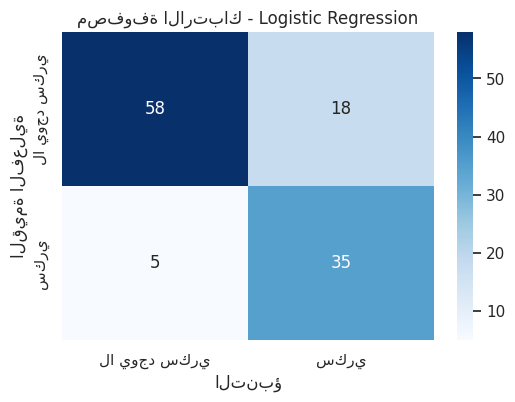

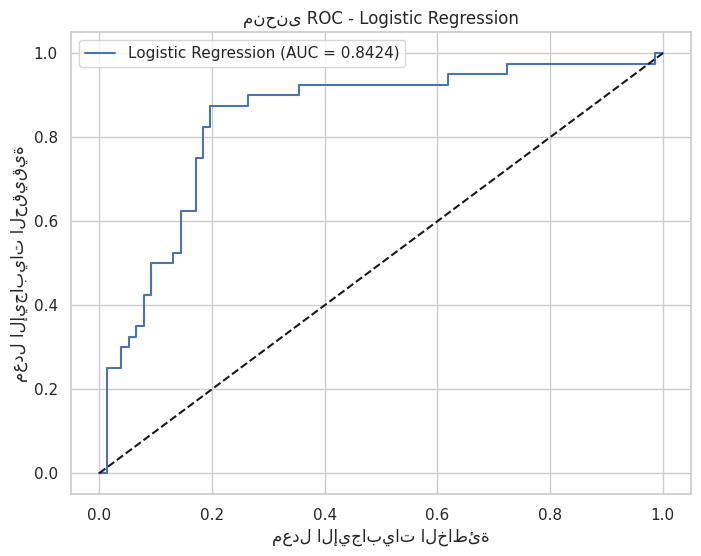


--------------------------------------------------
جاري تدريب وتقييم نموذج Random Forest...
نتائج Random Forest:
الدقة: 0.8793, AUC: 0.9558, التحقق الصاروخي: 0.8727, الوقت: 0.29ث
تقرير التصنيف:
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        76
           1       0.81      0.85      0.83        40

    accuracy                           0.88       116
   macro avg       0.86      0.87      0.87       116
weighted avg       0.88      0.88      0.88       116



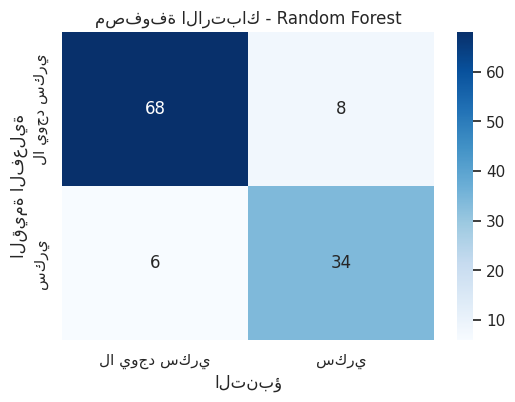

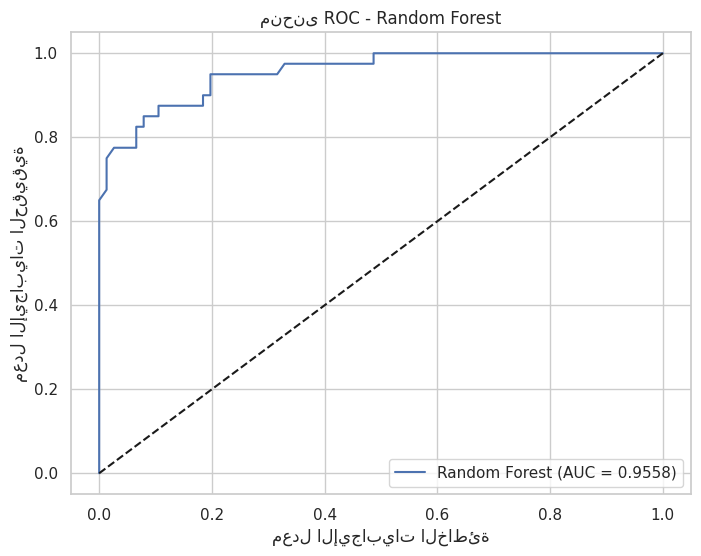


--------------------------------------------------
جاري تدريب وتقييم نموذج SVM...
نتائج SVM:
الدقة: 0.8534, AUC: 0.8855, التحقق الصاروخي: 0.8604, الوقت: 0.09ث
تقرير التصنيف:
              precision    recall  f1-score   support

           0       0.92      0.86      0.88        76
           1       0.76      0.85      0.80        40

    accuracy                           0.85       116
   macro avg       0.84      0.85      0.84       116
weighted avg       0.86      0.85      0.86       116



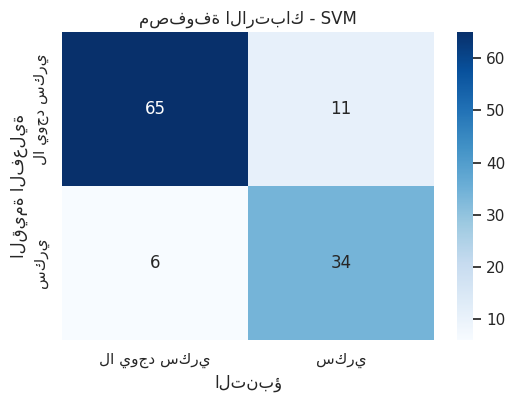

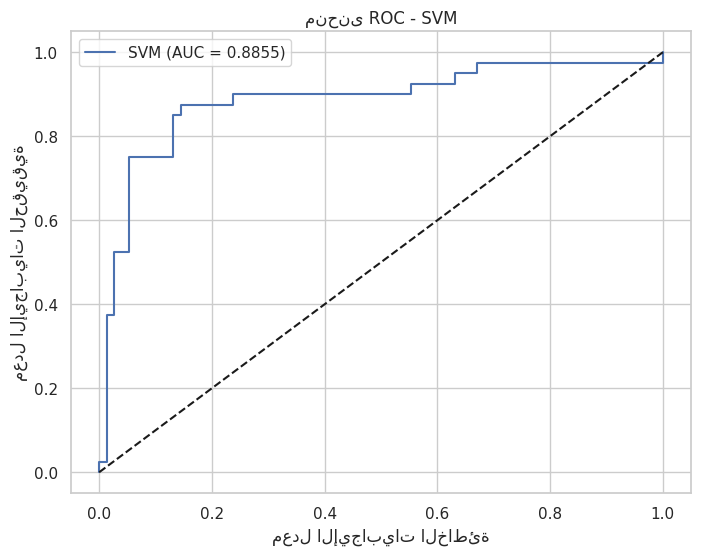


--------------------------------------------------
جاري تدريب وتقييم نموذج KNN...
نتائج KNN:
الدقة: 0.8017, AUC: 0.8868, التحقق الصاروخي: 0.8451, الوقت: 0.02ث
تقرير التصنيف:
              precision    recall  f1-score   support

           0       0.90      0.79      0.84        76
           1       0.67      0.82      0.74        40

    accuracy                           0.80       116
   macro avg       0.78      0.81      0.79       116
weighted avg       0.82      0.80      0.81       116



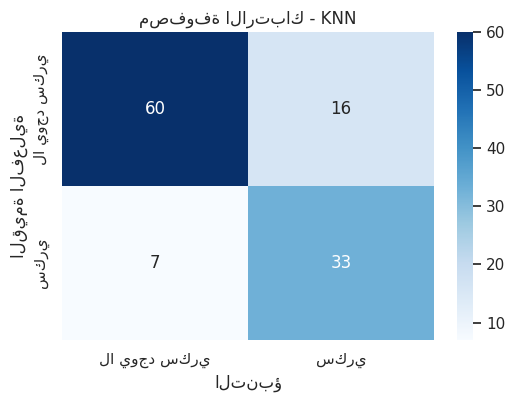

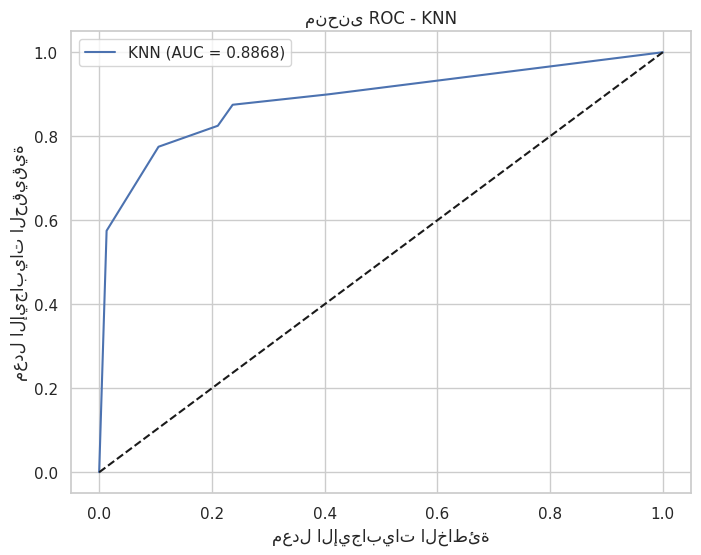


--------------------------------------------------
جاري تدريب وتقييم نموذج XGBoost...
نتائج XGBoost:
الدقة: 0.8879, AUC: 0.9523, التحقق الصاروخي: 0.8682, الوقت: 0.10ث
تقرير التصنيف:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        76
           1       0.81      0.88      0.84        40

    accuracy                           0.89       116
   macro avg       0.87      0.88      0.88       116
weighted avg       0.89      0.89      0.89       116



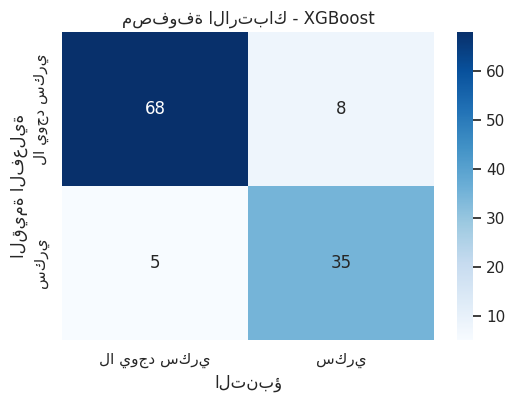

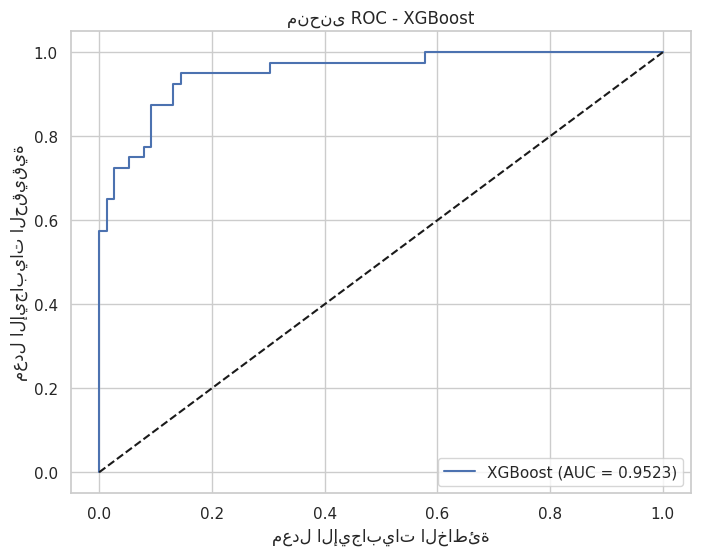


--------------------------------------------------
جاري تدريب وتقييم نموذج LightGBM...
[LightGBM] [Info] Number of positive: 424, number of negative: 424
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 848, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
نتائج LightGBM:
الدقة: 0.8621, AUC: 0.9454, التحقق الصاروخي: 0.8620, الوقت: 0.12ث
تقرير التصنيف:
       

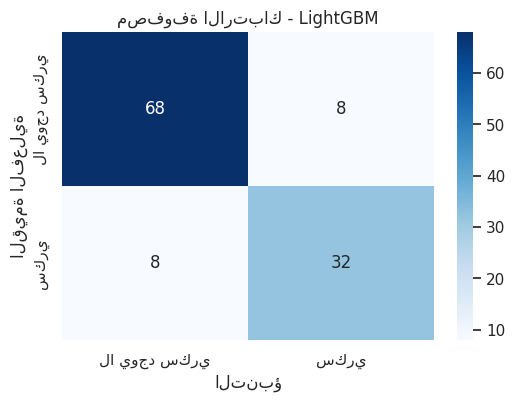

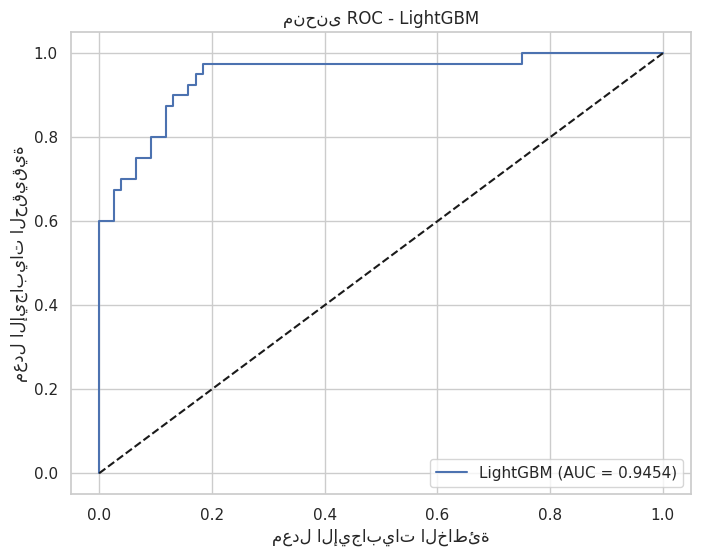


--------------------------------------------------
جاري تدريب وتقييم نموذج CatBoost...
نتائج CatBoost:
الدقة: 0.8879, AUC: 0.9516, التحقق الصاروخي: 0.8620, الوقت: 3.38ث
تقرير التصنيف:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91        76
           1       0.81      0.88      0.84        40

    accuracy                           0.89       116
   macro avg       0.87      0.88      0.88       116
weighted avg       0.89      0.89      0.89       116



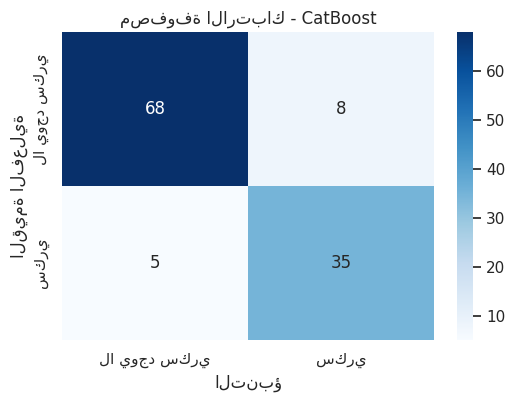

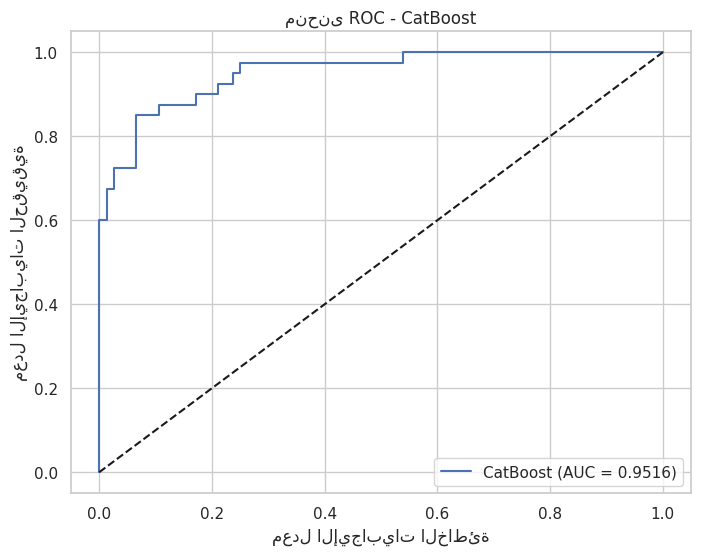


--------------------------------------------------
جاري تدريب وتقييم نموذج Gradient Boosting...
نتائج Gradient Boosting:
الدقة: 0.8707, AUC: 0.9523, التحقق الصاروخي: 0.8574, الوقت: 0.42ث
تقرير التصنيف:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90        76
           1       0.79      0.85      0.82        40

    accuracy                           0.87       116
   macro avg       0.85      0.87      0.86       116
weighted avg       0.87      0.87      0.87       116



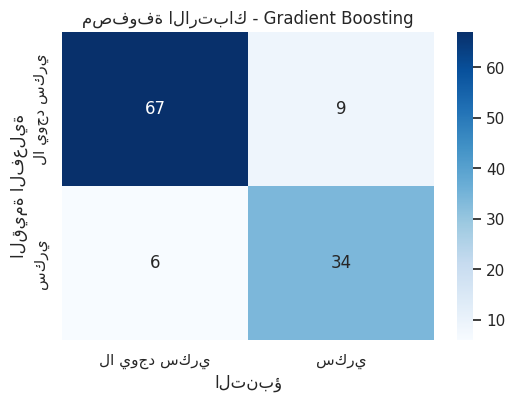

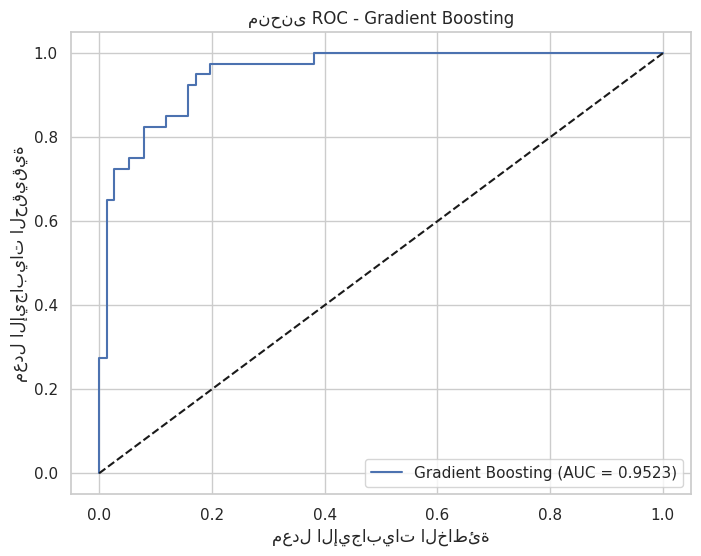

In [35]:
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(random_state=RANDOM_STATE),
    'SVM': SVC(probability=True, random_state=RANDOM_STATE),
    'KNN': KNeighborsClassifier(),
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, random_state=RANDOM_STATE),
    'LightGBM': LGBMClassifier(random_state=RANDOM_STATE),
    'CatBoost': CatBoostClassifier(silent=True, random_state=RANDOM_STATE),
    'Gradient Boosting': GradientBoostingClassifier(random_state=RANDOM_STATE)
}

# 8.2 تدريب وتقييم النماذج
results = []
best_model = None
best_accuracy = 0

for name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"جاري تدريب وتقييم نموذج {name}...")

    # إنشاء خط الأنابيب
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    # تدريب النموذج
    start_time_model = time.time()
    pipeline.fit(X_train, y_train)
    train_time = time.time() - start_time_model

    # التنبؤ والتقييم
    y_pred = pipeline.predict(X_test)
    y_prob = pipeline.predict_proba(X_test)[:, 1]

    # حساب المقاييس
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    # التحقق الصاروخي
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    cv_accuracy = np.mean(cv_scores)

    # حفظ النتائج
    results.append({
        'Model': name,
        'Accuracy': acc,
        'AUC': auc,
        'CV Accuracy': cv_accuracy,
        'Time (s)': train_time
    })

    # تحديث أفضل نموذج
    if acc > best_accuracy:
        best_accuracy = acc
        best_model = pipeline

    print(f"نتائج {name}:")
    print(f"الدقة: {acc:.4f}, AUC: {auc:.4f}, التحقق الصاروخي: {cv_accuracy:.4f}, الوقت: {train_time:.2f}ث")
    print("تقرير التصنيف:")
    print(classification_report(y_test, y_pred))

    # مصفوفة الارتباك
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['لا يوجد سكري', 'سكري'],
                yticklabels=['لا يوجد سكري', 'سكري'])
    plt.title(f'مصفوفة الارتباك - {name}')
    plt.xlabel('التنبؤ')
    plt.ylabel('القيمة الفعلية')
    plt.show()

    # منحنى ROC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('معدل الإيجابيات الخاطئة')
    plt.ylabel('معدل الإيجابيات الحقيقية')
    plt.title(f'منحنى ROC - {name}')
    plt.legend()
    plt.show()


##Results of Models

In [29]:
results_df = pd.DataFrame(results)
print("\n" + "="*50)
print("النتائج الأولية للنماذج:")
print("="*50)
print(results_df.sort_values('Accuracy', ascending=False))



النتائج الأولية للنماذج:
                 Model  Accuracy       AUC  CV Accuracy  Time (s)
6             CatBoost  0.887931  0.951645     0.862008  4.553868
4              XGBoost  0.887931  0.952303     0.868197  0.173522
1        Random Forest  0.879310  0.955757     0.872719  0.942118
7    Gradient Boosting  0.870690  0.952303     0.857428  0.489131
5             LightGBM  0.862069  0.945395     0.862008  0.161654
2                  SVM  0.853448  0.885526     0.860388  0.097371
3                  KNN  0.801724  0.886842     0.845085  0.013083
0  Logistic Regression  0.801724  0.842434     0.840458  0.028434


##Top Model

In [30]:
top_models = results_df.sort_values('Accuracy', ascending=False).head(2)['Model'].values
print(f"أفضل نموذجين للتحسين: {top_models}")

for model_name in top_models:
    print(f"\nجاري تحسين نموذج {model_name}...")

    # تعريف خط الأنابيب
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', models[model_name])
    ])

    # تعريف مساحة المعلمات
    param_grid = {}

    if model_name == 'Random Forest':
        param_grid = {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__max_depth': [5, 10, 15, None],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2, 4]
        }
    elif model_name == 'XGBoost':
        param_grid = {
            'classifier__n_estimators': [100, 200, 300],
            'classifier__learning_rate': [0.01, 0.05, 0.1],
            'classifier__max_depth': [3, 5, 7],
            'classifier__subsample': [0.8, 0.9, 1.0]
        }

    # البحث عن أفضل المعلمات
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring='accuracy',
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE),
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    # تقييم أفضل نموذج
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"\nأفضل معلمات لـ {model_name}:")
    print(grid_search.best_params_)
    print(f"دقة أفضل نموذج: {acc:.4f}")
    print(f"AUC أفضل نموذج: {auc:.4f}")

    # تحديث النتائج
    results_df.loc[results_df['Model'] == model_name, 'Accuracy'] = acc
    results_df.loc[results_df['Model'] == model_name, 'AUC'] = auc


أفضل نموذجين للتحسين: ['CatBoost' 'XGBoost']

جاري تحسين نموذج CatBoost...
Fitting 5 folds for each of 1 candidates, totalling 5 fits

أفضل معلمات لـ CatBoost:
{}
دقة أفضل نموذج: 0.8879
AUC أفضل نموذج: 0.9516

جاري تحسين نموذج XGBoost...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

أفضل معلمات لـ XGBoost:
{'classifier__learning_rate': 0.05, 'classifier__max_depth': 5, 'classifier__n_estimators': 100, 'classifier__subsample': 0.9}
دقة أفضل نموذج: 0.8966
AUC أفضل نموذج: 0.9576


##pipeline

In [33]:
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('cat', models['CatBoost']),
        ('rf', models['Random Forest'])
    ],
    voting='soft'
)

voting_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', voting_clf)
])

voting_pipeline.fit(X_train, y_train)
y_pred_voting = voting_pipeline.predict(X_test)
y_prob_voting = voting_pipeline.predict_proba(X_test)[:, 1]
acc_voting = accuracy_score(y_test, y_pred_voting)
auc_voting = roc_auc_score(y_test, y_prob_voting)


##Final comparison of model performance

In [37]:
voting_clf = VotingClassifier(
    estimators=[
        ('xgb', models['XGBoost']),
        ('cat', models['CatBoost']),
        ('rf', models['Random Forest'])
    ],
    voting='soft'
)

voting_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', voting_clf)
])

voting_pipeline.fit(X_train, y_train)
y_pred_voting = voting_pipeline.predict(X_test)
y_prob_voting = voting_pipeline.predict_proba(X_test)[:, 1]
acc_voting = accuracy_score(y_test, y_pred_voting)
auc_voting = roc_auc_score(y_test, y_prob_voting)

voting_result_df = pd.DataFrame([{
    'Model': 'Voting Classifier',
    'Accuracy': acc_voting,
    'AUC': auc_voting,
    'CV Accuracy': np.nan,
    'Time (s)': time.time() - start_time
}])

results_df = pd.concat([results_df, voting_result_df], ignore_index=True)


print(f"دقة نموذج التجميع: {acc_voting:.4f}")
print(f"AUC نموذج التجميع: {auc_voting:.4f}")

# ===== الخطوة 10: النتائج النهائية =====
print("\n" + "="*50)
print("9. النتائج النهائية")
print("="*50)

# 10.1 عرض النتائج
print("\n" + "="*50)
print("مقارنة نهائية لأداء النماذج:")
print("="*50)
final_results = results_df.sort_values('Accuracy', ascending=False)
print(final_results)

دقة نموذج التجميع: 0.8707
AUC نموذج التجميع: 0.9595

9. النتائج النهائية

مقارنة نهائية لأداء النماذج:
                 Model  Accuracy       AUC  CV Accuracy     Time (s)
4              XGBoost  0.896552  0.957566     0.868197     0.173522
6             CatBoost  0.887931  0.951645     0.862008     4.553868
1        Random Forest  0.879310  0.955757     0.872719     0.942118
8    Voting Classifier  0.870690  0.959539          NaN  1082.999547
7    Gradient Boosting  0.870690  0.952303     0.857428     0.489131
5             LightGBM  0.862069  0.945395     0.862008     0.161654
2                  SVM  0.853448  0.885526     0.860388     0.097371
0  Logistic Regression  0.801724  0.842434     0.840458     0.028434
3                  KNN  0.801724  0.886842     0.845085     0.013083


##Model Comparison - Accuracy Scores

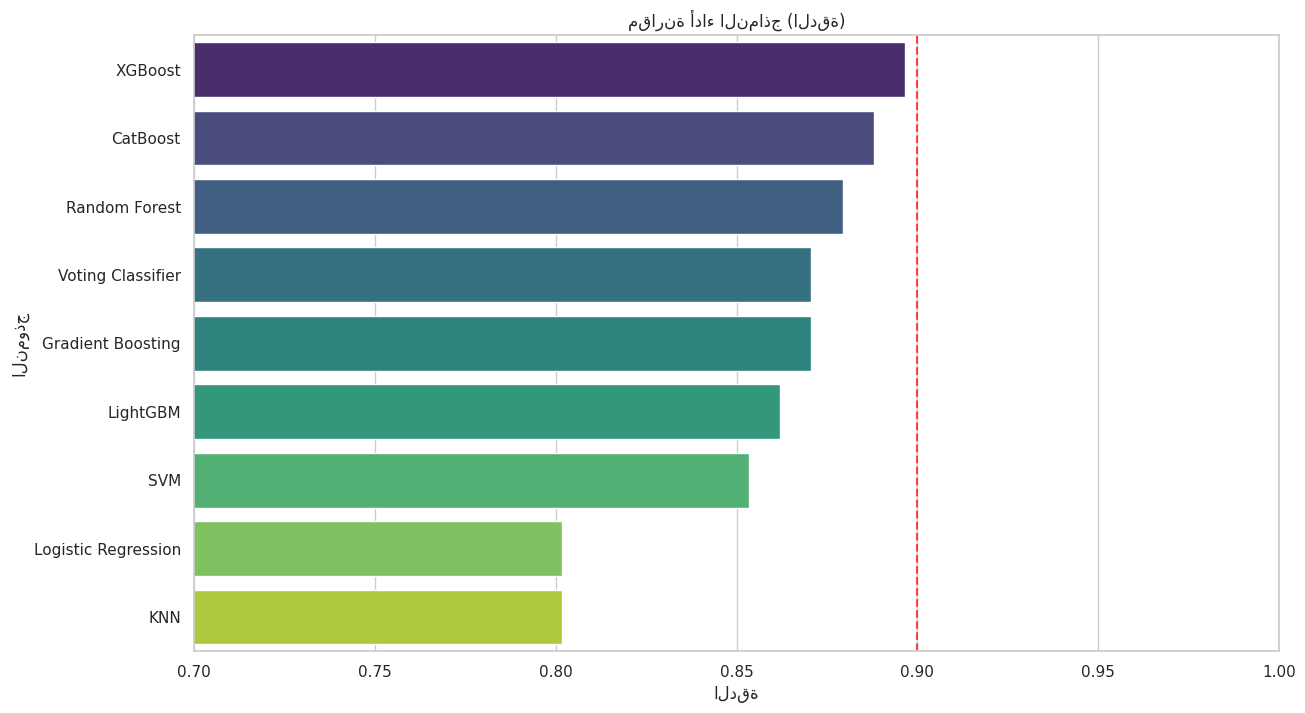

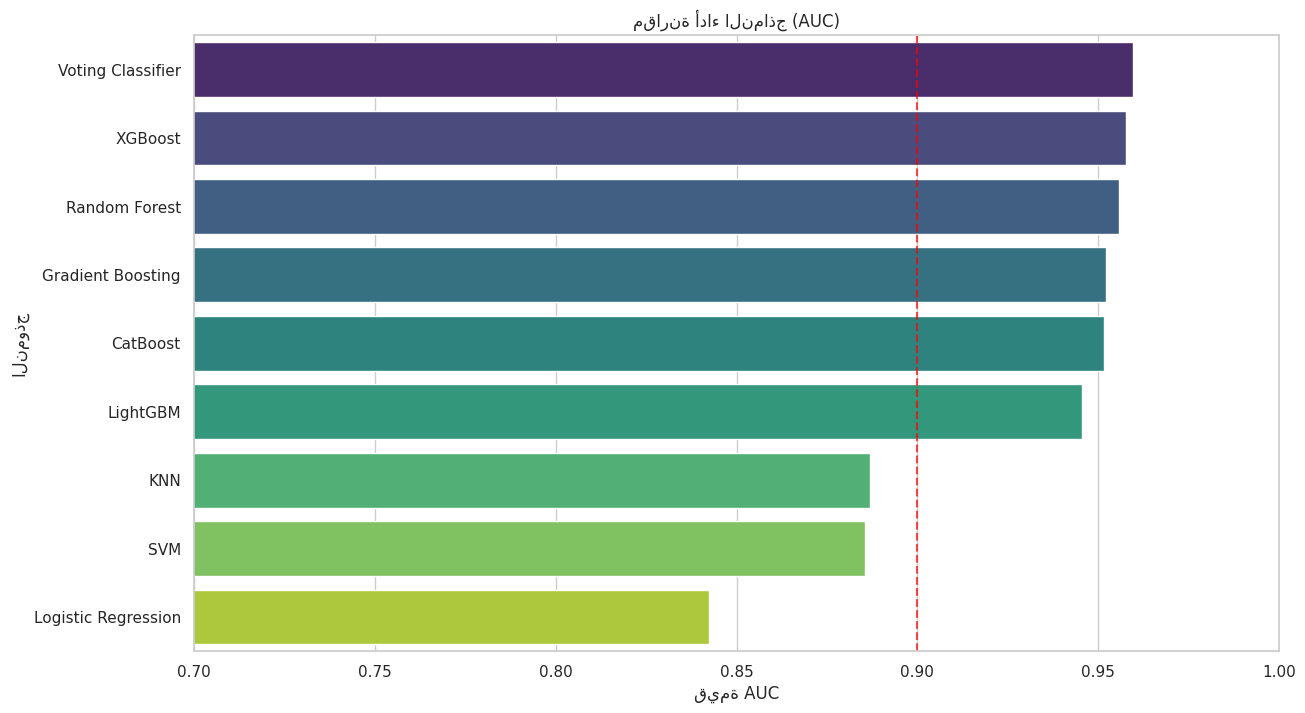

In [38]:
plt.figure(figsize=(14, 8))
sns.barplot(x='Accuracy', y='Model', data=final_results.sort_values('Accuracy', ascending=False),
            palette='viridis')
plt.title('مقارنة أداء النماذج (الدقة)')
plt.xlabel('الدقة')
plt.ylabel('النموذج')
plt.xlim(0.7, 1.0)
plt.axvline(x=0.90, color='red', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(14, 8))
sns.barplot(x='AUC', y='Model', data=final_results.sort_values('AUC', ascending=False),
            palette='viridis')
plt.title('مقارنة أداء النماذج (AUC)')
plt.xlabel('قيمة AUC')
plt.ylabel('النموذج')
plt.xlim(0.7, 1.0)
plt.axvline(x=0.90, color='red', linestyle='--', alpha=0.7)
plt.show()


##Best Model

In [40]:
# 10.3 أفضل نموذج
best_final_model = final_results.iloc[0]
print("\n" + "="*50)
print(f"أفضل نموذج: {best_final_model['Model']}")
print(f"الدقة: {best_final_model['Accuracy']:.4f}")
print(f"AUC: {best_final_model['AUC']:.4f}")
print("="*50)



أفضل نموذج: XGBoost
الدقة: 0.8966
AUC: 0.9576
